In [1]:
import warnings
from typing import Any
import joblib
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score, auc

from utils import plot_roc
import ml_utils as utils
from ml_utils import get_weights_for_roc_auc, weighted_roc_metric, get_optimal_trs, plot_roc, get_tpr_fpr, plot_roc_curves
import train


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

# datasets
dataset_type_6_test = "magn_6_aft_test"
dataset_type_6_without_test = "magn_6_withoutaft_test"
dataset_type_3_5_test = "magn_3_5_aft_test"
dataset_type_3_5_without_test = "magn_3_5_withoutaft_test"

dataset_type_6_train = "magn_6_aft"
dataset_type_6_without_train = "magn_6_withoutaft"
dataset_type_3_5_train = "magn_3_5_aft_train"
dataset_type_3_5_without_train = "magn_3_5_withoutaft_train"

test_6_path = f"data/dataset/{dataset_type_6_test}_trs6.0.parquet"
test_6_without_path = f"data/dataset/{dataset_type_6_without_test}_trs6.0.parquet"
test_3_5_path = f"data/dataset/{dataset_type_3_5_test}.parquet"
test_3_5_without_path = f"data/dataset/{dataset_type_3_5_without_test}.parquet"

train_6_path = f"data/dataset/{dataset_type_6_train}_trs6.0.parquet"
train_6_without_path = f"data/dataset/{dataset_type_6_without_train}_trs6.0.parquet"
train_3_5_path = f"data/dataset/{dataset_type_3_5_train}.parquet"
train_3_5_without_path = f"data/dataset/{dataset_type_3_5_without_train}.parquet"

# models
aft_6_logreg = "data/models/aft_6_logreg.pickle"
withoutaft_6_logreg = "data/models/withoutaft_6_logreg.pickle"
aft_3_5_logreg = "data/models/aft_3_5_logreg.pickle"
withoutaft_3_5_logreg = "data/models/withoutaft_3_5_logreg.pickle"

# config_dict
config_dict = {
    "aft_3_5": {
        "name": "magnitude > 3.5 | with aftershocks",
        "train": train_3_5_path,
        "test": test_3_5_path,
        "model": aft_3_5_logreg,
    },
    "withoutaft_3_5": {
        "name": "magnitude > 3.5 | without aftershocks",
        "train": train_3_5_without_path,
        "test": test_3_5_without_path,
        "model": withoutaft_3_5_logreg,
    },
    "aft_6": {
        "name": "magnitude > 6 | with aftershocks",
        "train": train_6_path,
        "test": test_6_path,
        "model": aft_6_logreg,
    },
    "withoutaft_6": {
        "name": "magnitude > 6 | without aftershocks",
        "train": train_6_without_path,
        "test": test_6_without_path,
        "model": withoutaft_6_logreg,
    },
}

train_path: data/dataset/magn_6_aft_trs6.0.parquet
test_path: data/dataset/magn_6_aft_test_trs6.0.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-17 — 2020-08-13
test dates: 2020-10-14 — 2023-05-09

train: target==0: 524970, target==1: 1980
test: target==0: 210320, target==1: 730
target class proportion: test: 0.0034709014834537846, train: 0.0037716440939482257


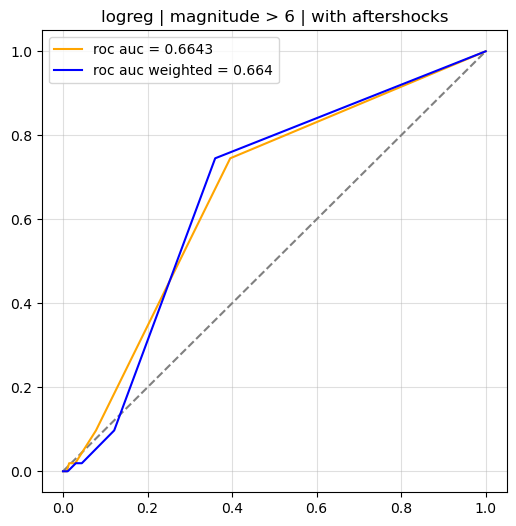

In [3]:
# aft 6
data_type = "aft_6"
TEST_PATH = config_dict[data_type]["test"]
TRAIN_PATH = config_dict[data_type]["train"]
MODEL_PATH = config_dict[data_type]["model"]
TITLE = f"logreg | {config_dict[data_type]['name']}"

_, test_df = utils.get_train_test_datasets(
    train_path=TRAIN_PATH, test_path=TEST_PATH, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

feature_cols = list(set(test_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_test, y_test = features.make_features_target(test_df)
y_test = y_test[target]

# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date, trs=3.0)

aft_logreg_model = joblib.load(open(MODEL_PATH, "rb"))
y_pred_prob = aft_logreg_model.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, title=TITLE, n=100)

train_path: data/dataset/magn_6_withoutaft_trs6.0.parquet
test_path: data/dataset/magn_6_withoutaft_test_trs6.0.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-17 — 2020-08-13
test dates: 2020-10-14 — 2023-05-09

train: target==0: 237884, target==1: 1000
test: target==0: 95163, target==1: 513
target class proportion: test: 0.005390750606853504, train: 0.0042037295488557445


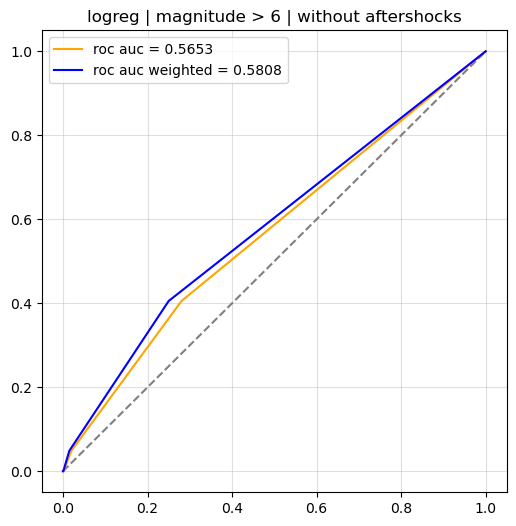

In [4]:
# without aft 6
data_type = "withoutaft_6"
TEST_PATH = config_dict[data_type]["test"]
TRAIN_PATH = config_dict[data_type]["train"]
MODEL_PATH = config_dict[data_type]["model"]
TITLE = f"logreg | {config_dict[data_type]['name']}"

_, test_df = utils.get_train_test_datasets(
    train_path=TRAIN_PATH, test_path=TEST_PATH, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

feature_cols = list(set(test_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_test, y_test = features.make_features_target(test_df)
y_test = y_test[target]

# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date, trs=3.0)

aft_logreg_model = joblib.load(open(MODEL_PATH, "rb"))
y_pred_prob = aft_logreg_model.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, title=TITLE, n=100)

In [5]:
roc_auc_score(y_test, y_pred_prob[:, 1])

0.6410100109550416

In [6]:
data_type = "aft_3_5"
config_dict[data_type]

{'name': 'magnitude > 3.5 | with aftershocks',
 'train': 'data/dataset/magn_3_5_aft_train.parquet',
 'test': 'data/dataset/magn_3_5_aft_test.parquet',
 'model': 'data/models/aft_3_5_logreg.pickle'}

logreg | magnitude > 3.5 | with aftershocks
train_path: data/dataset/magn_3_5_aft_train.parquet
test_path: data/dataset/magn_3_5_aft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-08-26
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1593709, target==1: 27847
test: target==0: 6428932, target==1: 98518
target class proportion: test: 0.015324162706962836, train: 0.01747307695445028


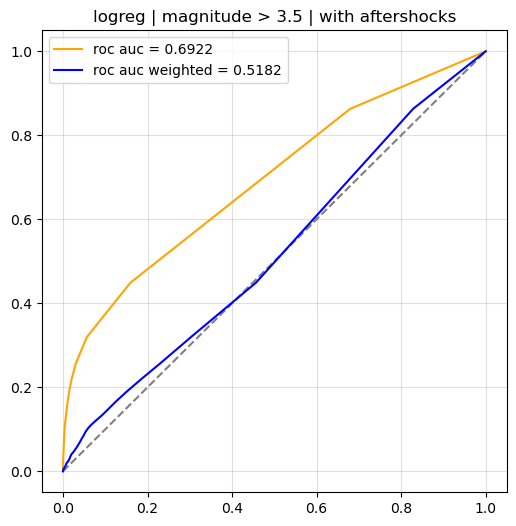

In [7]:
# aft 3.5
data_type = "aft_3_5"
TEST_PATH = config_dict[data_type]["test"]
TRAIN_PATH = config_dict[data_type]["train"]
MODEL_PATH = config_dict[data_type]["model"]
TITLE = f"logreg | {config_dict[data_type]['name']}"

print(TITLE)

_, test_df = utils.get_train_test_datasets(
    train_path=TRAIN_PATH, test_path=TEST_PATH, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

feature_cols = list(set(test_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_test, y_test = features.make_features_target(test_df)
y_test = y_test[target]

# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date, trs=3.0)

aft_logreg_model = joblib.load(open(MODEL_PATH, "rb"))
y_pred_prob = aft_logreg_model.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, title=TITLE, n=100)

In [8]:
roc_auc_score(y_test, y_pred_prob[:, 1])

0.7047621877917829

In [9]:
len(np.unique(y_pred_prob[:, 1]))

750640

logreg | magnitude > 3.5 | without aftershocks
train_path: data/dataset/magn_3_5_withoutaft_train.parquet
test_path: data/dataset/magn_3_5_withoutaft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-10-05
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1129198, target==1: 8402
test: target==0: 4461907, target==1: 41093
target class proportion: test: 0.009209739243780742, train: 0.007440679136874136


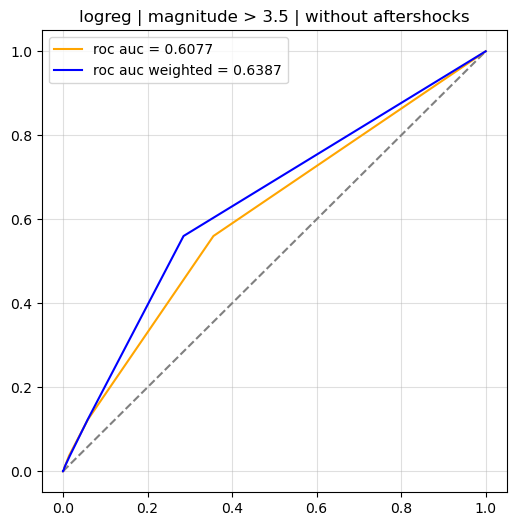

In [10]:
# withoutaft 3.5
data_type = "withoutaft_3_5"
TEST_PATH = config_dict[data_type]["test"]
TRAIN_PATH = config_dict[data_type]["train"]
MODEL_PATH = config_dict[data_type]["model"]
TITLE = f"logreg | {config_dict[data_type]['name']}"

print(TITLE)

_, test_df = utils.get_train_test_datasets(
    train_path=TRAIN_PATH, test_path=TEST_PATH, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

feature_cols = list(set(test_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_test, y_test = features.make_features_target(test_df)
y_test = y_test[target]

# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date, trs=3.0)

aft_logreg_model = joblib.load(MODEL_PATH)
y_pred_prob = aft_logreg_model.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, title=TITLE, n=100)

In [11]:
roc_auc_score(y_test, y_pred_prob[:, 1])

0.6420857338373641

In [12]:
len(np.unique(y_pred_prob[:, 1]))

4479162

In [13]:
config_dict

{'aft_3_5': {'name': 'magnitude > 3.5 | with aftershocks',
  'train': 'data/dataset/magn_3_5_aft_train.parquet',
  'test': 'data/dataset/magn_3_5_aft_test.parquet',
  'model': 'data/models/aft_3_5_logreg.pickle'},
 'withoutaft_3_5': {'name': 'magnitude > 3.5 | without aftershocks',
  'train': 'data/dataset/magn_3_5_withoutaft_train.parquet',
  'test': 'data/dataset/magn_3_5_withoutaft_test.parquet',
  'model': 'data/models/withoutaft_3_5_logreg.pickle'},
 'aft_6': {'name': 'magnitude > 6 | with aftershocks',
  'train': 'data/dataset/magn_6_aft_trs6.0.parquet',
  'test': 'data/dataset/magn_6_aft_test_trs6.0.parquet',
  'model': 'data/models/aft_6_logreg.pickle'},
 'withoutaft_6': {'name': 'magnitude > 6 | without aftershocks',
  'train': 'data/dataset/magn_6_withoutaft_trs6.0.parquet',
  'test': 'data/dataset/magn_6_withoutaft_test_trs6.0.parquet',
  'model': 'data/models/withoutaft_6_logreg.pickle'}}

In [14]:
# plot all types, weighted roc
fpr_tpr_dict = {}
for data_type in config_dict:
    TEST_PATH = config_dict[data_type]["test"]
    TRAIN_PATH = config_dict[data_type]["train"]
    MODEL_PATH = config_dict[data_type]["model"]

    _, test_df = utils.get_train_test_datasets(
        train_path=TRAIN_PATH, test_path=TEST_PATH, 
        min_test_date = min_test_date, min_train_date = min_train_date
    )
    
    feature_cols = list(set(test_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))
    
    # train, test
    features = utils.Features(
        features=feature_cols, target=target, dt_col=dt_col, 
        groupby=["cell_x", "cell_y"], target_features=[]
    )
    
    X_test, y_test = features.make_features_target(test_df)
    y_test = y_test[target]
    roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date, trs=3.0)
    
    logreg_model = joblib.load(open(MODEL_PATH, "rb"))
    y_pred_prob = logreg_model.predict_proba(X_test)
    tpr, fpr = get_tpr_fpr(y_test, y_pred_prob[:, 1], sample_weight=roc_auc_weights_test, n=1_000)
    fpr_tpr_dict[data_type] = {"tpr": tpr.copy(), "fpr": fpr.copy()}

train_path: data/dataset/magn_3_5_aft_train.parquet
test_path: data/dataset/magn_3_5_aft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-08-26
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1593709, target==1: 27847
test: target==0: 6428932, target==1: 98518
target class proportion: test: 0.015324162706962836, train: 0.01747307695445028


train_path: data/dataset/magn_3_5_withoutaft_train.parquet
test_path: data/dataset/magn_3_5_withoutaft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-10-05
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1129198, target==1: 8402
test: target==0: 4461907, target==1: 41093
target class proportion: test: 0.009209739243780742, train: 0.007440679136874136


train_path: data/dataset/magn_6_aft_trs6.0.parquet
test_path: data/dataset/magn_6_aft_test_trs6.0.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-17 — 2020-08-13
test dates: 2020-10-14 — 2023-05-09

train: target==0: 524970, target==1: 1980
test: target==0: 210320, target==1: 730
target class proportion: test: 0.0034709014834537846, train: 0.0037716440939482257


train_path: data/dataset/magn_6_withoutaft_trs6.0.parquet
test_path: data/dataset/magn_6_withoutaft_test_trs6.0.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-17 — 2020-08-13
test dates: 2020-10-14 — 2023-05-09

train: target==0: 237884, target==1: 1000
test: target==0: 95163, target==1: 513
target class proportion: test: 0.005390750606853504, train: 0.0042037295488557445


In [15]:
(
    auc(fpr_tpr_dict["aft_3_5"]["fpr"], fpr_tpr_dict["aft_3_5"]["tpr"]),
    auc(fpr_tpr_dict["aft_6"]["fpr"], fpr_tpr_dict["aft_6"]["tpr"])
)

(0.51833549647842, 0.649542774265916)

In [16]:
(
    auc(fpr_tpr_dict["aft_3_5"]["fpr"], fpr_tpr_dict["aft_3_5"]["tpr"]),
    auc(fpr_tpr_dict["aft_6"]["fpr"], fpr_tpr_dict["aft_6"]["tpr"])
)

(0.51833549647842, 0.649542774265916)

In [17]:
with open("data/models/logreg_fpr_tpr.json", 'w') as json_file:
    json.dump(fpr_tpr_dict, json_file, indent=4)

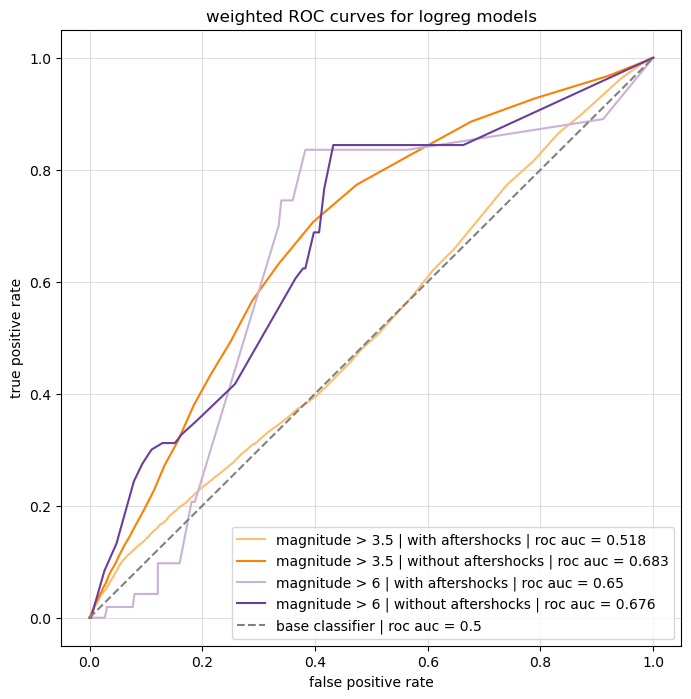

In [18]:
# Plotting the ROC curves
fpr_tpr_dict = json.load(open("data/models/logreg_fpr_tpr.json", 'r'))
colors = plt.cm.Paired(range(6, 6+len(fpr_tpr_dict)))

plt.figure(figsize=(8, 8), dpi=100)

for data_type, values in fpr_tpr_dict.items():
    fpr, tpr = values["fpr"], values["tpr"]
    roc_auc_w = round(auc(fpr, tpr), 3)
    label = f"{config_dict[data_type]['name']} | roc auc = {roc_auc_w}"
    plt.plot(fpr, tpr, color=colors[list(fpr_tpr_dict.keys()).index(data_type)], label=label)

# ROC curve data for a random classifier
fpr_random, tpr_random = [0, 1], [0, 1]
plt.plot(fpr_random, tpr_random, c="grey", ls='--', label = "base classifier | roc auc = 0.5")

# Adding legend and grid
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('weighted ROC curves for logreg models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.4)
plt.show();